## Minimal Image Segmentation

In [1]:
from fastai2.vision.all import *
from pathlib import Path, PosixPath

In [2]:
## For debugging, run on CPU-only
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# Set the default path
path = Path("data/bluebirds")

In [4]:
# Here, we're building a data loader. 
# The most important part of this is making the correct custom paths
# for fnames, label_func, and codes are correct
# item_tfms and batch_tfms help with data augmentation
dls = SegmentationDataLoaders.from_label_func(
    path, bs=1, fnames = get_image_files(path/"resized_images"),
    label_func = lambda o: path/'resized_labels'/f'{o.stem}_watershed_mask{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str),
    item_tfms=RandomResizedCrop(180, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2)
)


In [5]:
learn = unet_learner(dls, resnet18, path=path)
learn.freeze()

In [6]:
#learn.fine_tune(10,3e-3)
# Let's just do this quickly for now
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.383454,1.091512,00:04


epoch,train_loss,valid_loss,time
0,0.850395,1.645735,00:01
1,0.705344,0.813824,00:01
2,0.770491,0.831942,00:01
3,0.740361,0.933825,00:01
4,0.676628,0.869572,00:01
5,0.677821,0.797959,00:01
6,0.619875,3.186500,00:01
7,0.612533,0.804362,00:01
8,0.575774,0.770077,00:01
9,0.559570,0.792569,00:01


In [7]:
#learn.show_results(figsize=(20,20))

In [8]:
model_name = 'bb_model'

In [9]:
learn.save(model_name)

In [10]:
assert (path/'models'/(model_name+'.pth')).exists()


eval_path = path/"eval_imgs"
fnames = get_image_files(eval_path)
def label_func(x): return eval_path/f'{x.stem}{x.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str)    
eval_dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, codes=codes,bs=1)

learn1 = unet_learner(eval_dls,arch=resnet18)
learn1 = learn1.load(model_name)

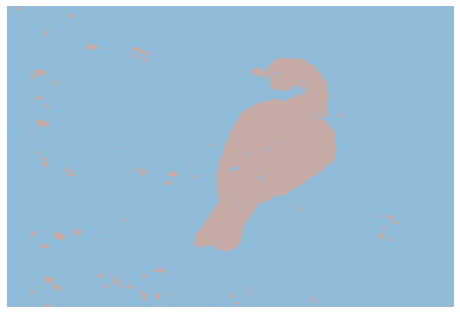

In [11]:
eval_img_path = path/'eval_imgs'/'eval_img2.png'
img = Image.open(eval_img_path)
prediction = learn1.predict(eval_img_path)
prediction[0].show(figsize=(8,8))